<a href="https://colab.research.google.com/github/safarie1103/dsc650/blob/master/ExternalResources/Real_Time_Big_Data_Streaming_Spark_Kafka-main/flight_kafka_consumer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=blue> Real Time Stock Ticker Streaming - Kafka Consumer </font>


In [ ]:
!pip install kafka-python

### Consuming data the data being streamed using Kafka and plotting it.

In [1]:
# import statements
import pandas as pd
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib
import numpy as np
import copy
import matplotlib.pyplot as plt
from json import loads

## Step 1

#### Set topic, connect consumer to producer and set plotting function

In [2]:
# set the topic of the consumer
topic = 'stock_ticker'

# function to connect to kafka consumer
# taken from tutorial week 9
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=240000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='latest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['192.168.86.48:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 11,5))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

    
# function to set up the plotting area
# taken from tutorial week 9
def init_plots():
    try:
        
        width = 15
        height = 15
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        #fig.suptitle('Technical Indicators') # giving figure a title
        #ax.set_xlabel('Date')
        #ax.set_ylabel('countFlightRecords')        
        #fig.show() # displaying the figure
        #fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [3]:
def GetStockData(consumer):
    for message in consumer: 
        data = []
        df = pd.DataFrame.from_dict(message.value)
        data.append(df)
                                

In [4]:
def bbands(price, length=30, numsd=3):    
    ave = price.rolling(window = length, center = False).mean()    
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [6]:
%matplotlib notebook
plt.style.use('fivethirtyeight')


def GetMessage(consumer,fig, ax):
    try:
        
        for message in consumer: 
                data = []
                #print("New Data...........")
                for stock in range(len(message.value)):            
                    df = pd.DataFrame.from_dict(message.value[stock])               
                    df['Date'] = pd.to_datetime(df['Date'])
                    df = df.reset_index()
                    df = df.set_index('Date')     
                    data.append(df)

                TechIndicator = copy.deepcopy(data)

                #print(TechIndicator[0].index)
                #print(len(TechIndicator))
                


                #"""
                
                for stock in range(len(TechIndicator)):
                    TechIndicator[stock]['BB_Middle_Band'], TechIndicator[stock]['BB_Upper_Band'], TechIndicator[stock]['BB_Lower_Band'] = bbands(TechIndicator[stock]['Close'], length=30, numsd=3)
                    TechIndicator[stock]['BB_Middle_Band'] = TechIndicator[stock]['BB_Middle_Band']
                    TechIndicator[stock]['BB_Upper_Band'] = TechIndicator[stock]['BB_Upper_Band']
                    TechIndicator[stock]['BB_Lower_Band'] = TechIndicator[stock]['BB_Lower_Band']
                    TechIndicator[stock] = TechIndicator[stock].dropna()
               
                for stock in range(len(TechIndicator)):
                    
                    CurrentValue = TechIndicator[stock]['Close'][len(TechIndicator[stock]['Close'])-1]
                    CurrentValue = round(CurrentValue,2)
                    #print('Current Value: ' , CurrentValue)
                    CurrentDate = TechIndicator[stock].index[len(TechIndicator[stock].index)-1]
                    #print('CurrentDate: ' , CurrentDate)
                    ax = plt.subplot(4,2,stock+1)
                    ax.clear()
                    ax.fill_between(TechIndicator[stock].index, TechIndicator[stock]['BB_Upper_Band'], TechIndicator[stock]['BB_Lower_Band'], color='grey', label="Band Range")
                    # Plot Adjust Closing Price and Moving Averages
                    ax.plot(TechIndicator[stock].index, TechIndicator[stock]['Close'], color='red', lw=2, label="Close")
                    ax.annotate(str(CurrentValue), (CurrentDate, CurrentValue),)
                    ax.plot(TechIndicator[stock].index, TechIndicator[stock]['BB_Middle_Band'], color='black', lw=2, label="Middle Band")
                    ax.set_title("Bollinger Bands for " + str(TechIndicator[stock]['Label'][0]))
                    ax.legend()
                    ax.set_xlabel("Date")
                    ax.set_ylabel("Value")
                    plt.xticks(rotation=30)
                
                fig.tight_layout()
                
                fig.canvas.draw()
                
        plt.close('all')
                #"""  
    except Exception as ex:
        print(str(ex))

     
         
        

<IPython.core.display.Javascript object>


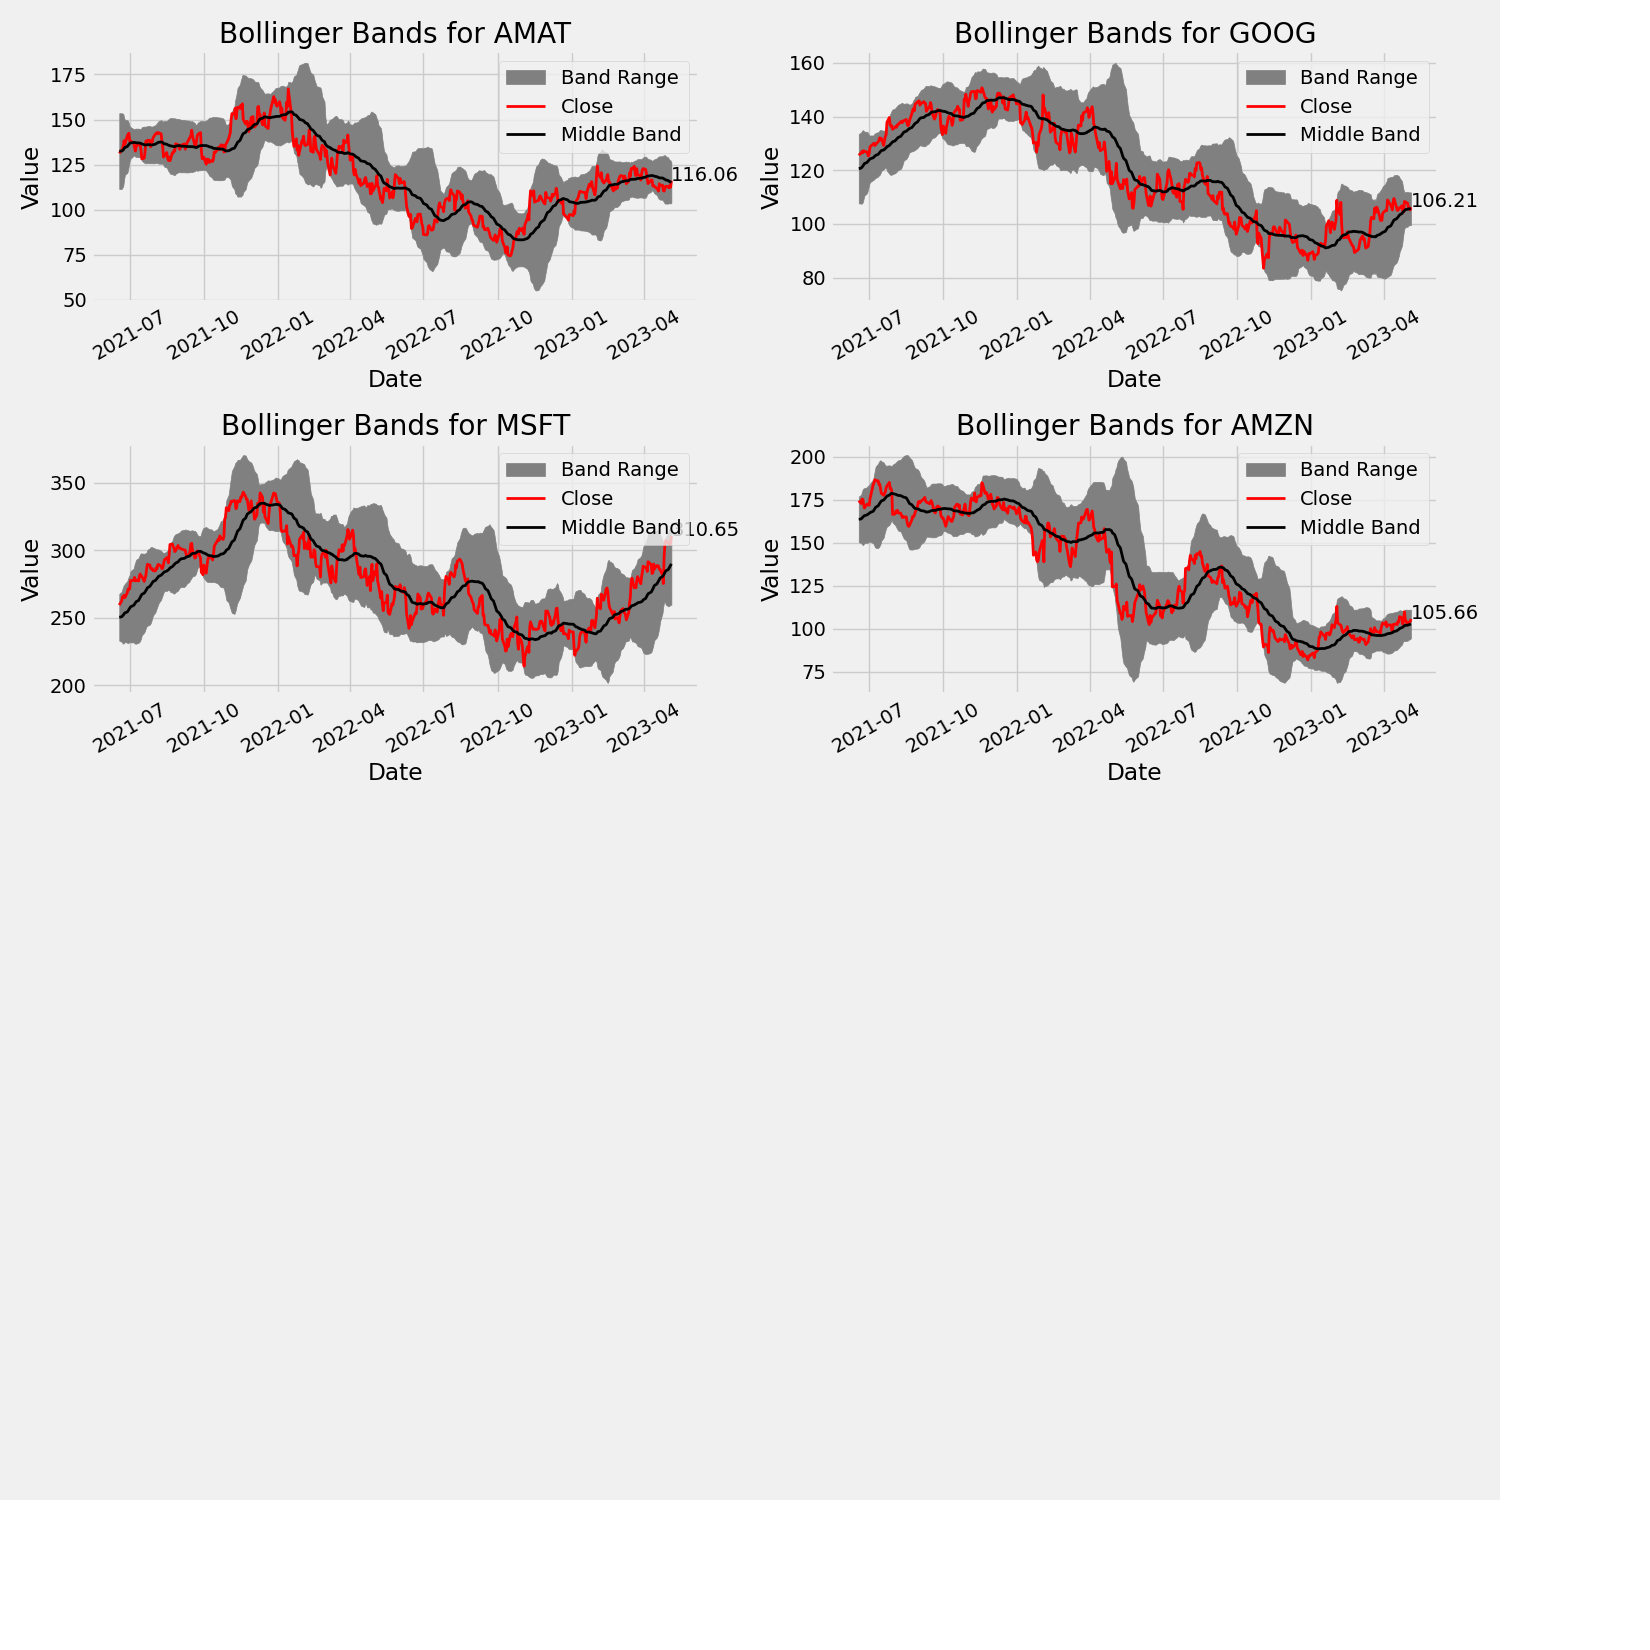

In [ ]:
if __name__ == '__main__':
    
    # call all required functions 
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()  
    GetMessage(consumer,fig, ax)        
    